In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [216]:
#data from a sample dataset for IBM's Watson service: https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/

This project is about trying to predict customer churn, for an anonymous Telco company. Given some data about various customer features as well as if that customer churned in the last month or not, can we create a predictive model for which customers might churn in the future?

We'll start by reading the data into a pandas dataframe and by taking a quick look at the data.

In [140]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn (1).csv')
samp = df.head(3).T
samp['unique_values'] = df.apply(lambda x: len(x.unique()))
samp['dtypes'] = df.dtypes.values
samp

,0,1,2,unique_values,dtypes
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7043,object
gender,Female,Male,Male,2,object
SeniorCitizen,0,0,0,2,int64
Partner,Yes,No,No,2,object
Dependents,No,No,No,2,object
tenure,1,34,2,73,int64
PhoneService,No,Yes,Yes,2,object
MultipleLines,No phone service,No,No,3,object
InternetService,DSL,DSL,DSL,3,object
OnlineSecurity,No,Yes,Yes,3,object


We have a label to predict (Churn), a few continuous-ish variables (MonthlyCharges,TotalCharges - I say continuous-ish because the number of unique prices as a result of the number of packages, discounts, etc.), and actual continual in tenure, and quite a few categoricals - some binary, some with several categories. Let's split these features up into groups, depending on what kind of processing they need.

In [183]:
df.drop('customerID', axis=1, inplace=True)

In [171]:
bool_features = ['Churn','PaperlessBilling','PhoneService','Dependents','Partner','SeniorCitizen']

Let's take a look at why TotalCharges is not being represented as a float

In [141]:
print(sorted(df['TotalCharges'].unique())[:5])
print(sorted(df['TotalCharges'].unique())[-5:])

[' ', '100.2', '100.25', '100.35', '100.4']
['997.75', '998.1', '999.45', '999.8', '999.9']


In [142]:
print(sum(df['TotalCharges']==' '))

df[df['TotalCharges']==' ']

11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


We're missing values for 11 Total Charges values. These values also have a tenure of 0, so my assumption is that TotalCharges is equivalent to the sum of MonthlyCharges value times the tenure of that charge.

We can draw some conclusions from this:
- First, we could either fill the missing values with 0, since the customer has not been charged yet, or drop the rows since none of these customers have churned. This would be a question to send back to the datasource - is there ever a scenario where a first month customer could churn? For now we'll drop the ' ' rows.
- Second, we might be able to determine if the customer has recently had their monthly charges increased or decreased by dividing total charges by tenure and comparing to the current monthly charges value. If the result is lower than monthly charges, the customer has seen a price increase vs. their overall average and visa versa. We'll take a look shortly to see if we can validate this.
- Third, this means that there is likely a high degree of correlation between some combination of tenure, monthly charges, and total charges. We'll need to account for this when we begin examing models.

In [144]:
df = df[df['TotalCharges']!=' ']
df['TotalCharges'] = df['TotalCharges'].astype(np.float64)

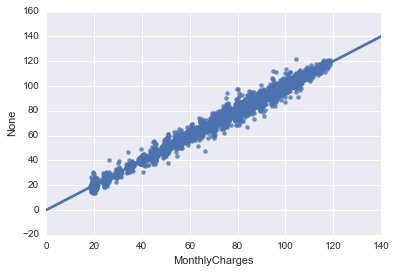

In [145]:
to_plt = df[df['tenure']>0]
sns.regplot(to_plt['MonthlyCharges'], to_plt['TotalCharges']/to_plt['tenure'])

Sure enough, there's a very strong relationship between MonthlyCharges and TotalCharges/tenure. It also looks there's enough variation to the data that we can experiment with a price change feature. Let's start with computing and storing the difference between TotalCharges/tenure and Monthly charges

In [147]:
df['PriceChange'] = df['MonthlyCharges'] - (df['TotalCharges']/df['tenure'])
df[['PriceChange','MonthlyCharges','TotalCharges','tenure']].head()

,PriceChange,MonthlyCharges,TotalCharges,tenure
0,0.000000,29.85,29.85,1
1,1.376471,56.95,1889.50,34
2,-0.225000,53.85,108.15,2
3,1.394444,42.30,1840.75,45
4,-5.125000,70.70,151.65,2


Let's go back to the other features - there's a number of features that look like they should be booleans - StreamingTV (Yes/No), but have 3 unique values. Let's see what else is going on:

In [154]:
df['StreamingTV'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [151]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

Our third value is equivalent to an NA for most columns. We could created dummy variables for all of the features, but that adds complexity, especially in understanding our results. It also creates a lot of redundancy, since the information is already contained in the InternetService field. Instead, let's rearrange things a bit - we'll split InternetService into [HasInternet, DSL, Fiber], and replace all "No internet service" values with "No". That maintains our information, while keeping the dataset more simple.

In [160]:
internet_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']
df[internet_columns] = df[internet_columns].replace(['Yes','No','No internet service'],[1,0,0])
df['HasInternet'] = df['InternetService']=='Yes'
df['DSL'] = df['InternetService']=='DSL'
df['Fiber'] = df['InternetService']=='Fiber'
df.drop('InternetService', axis=1, inplace=True)
df[['HasInternet','DSL','Fiber']] = df[['HasInternet','DSL','Fiber']].astype(int)

In [168]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
OnlineSecurity,0,1,1,1,0
OnlineBackup,1,0,1,0,0


We can do something similar for PhoneService and MultipleLines - PhoneService yes/no already tells us if MultipleLines should have No phone service, so we'll replace those values with 0 and convert to boolean.

In [169]:
df['MultipleLines'] = df['MultipleLines'].replace(['Yes','No','No phone service'],[1,0,0])
df['PhoneService'] = df['PhoneService'].replace(['Yes','No'],[1,0])

In [172]:
df[bool_features] = df[bool_features].replace(['Yes','No'],[1,0])

In [174]:
df['gender'] = df['gender'].replace(['Female','Male'],[1,0])

Contract and PaymentMethod are both categorical, but only with a few categories - we'll create dummy variables to encode the different possibilities.

In [178]:
dummies = pd.get_dummies(df[['Contract','PaymentMethod']])
df[dummies.columns] = dummies

In [184]:
df.drop(['Contract','PaymentMethod'], axis=1, inplace=True)

At this point, our data is ready for an initial run through a model training process. We'll use a basic test/train split with a Random Forest Classifier, just to get an idea of how our initial performance is and what features are standing out as meaningful.

In [191]:
X, y = df[df.columns.drop('Churn')], df['Churn']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [207]:
model = RandomForestClassifier()

In [208]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [209]:
pred = model.predict(X_test)

In [211]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86      1295
          1       0.64      0.45      0.53       463

avg / total       0.77      0.79      0.78      1758



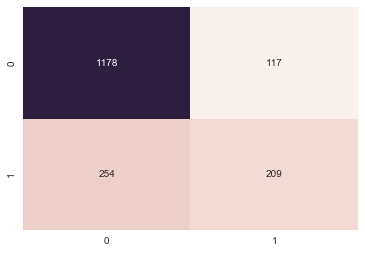

In [212]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False)

Results aren't too poor - the model is a bit biased towards predicting no churn vs. churn since it only predicted 326 churns when there was 463 in the test dataset. One approach we could take might be to use the result of predict_proba for a probability instead of class output, and select a threshold of churn that results in a better churn recall. The reason we might want to do this is because it's probably better to slightly over-predict churn and target those customers with marketing, instead of minizing false positives. The false positive outcome is not that bad (wasted spend on customers who might not churn), while false negatives are bad outcomes (customers who might have been convinced to stay if targeted). 

There's also the possiblity that some of the false positives actually will churn in the future, since there is likely similarities in their features vs. the features of churners.


Let's take a look at which features are most important to the model's decision making:

In [213]:
sorted(list(zip(X.columns,model.feature_importances_)), key=lambda x: x[1], reverse=True)

[('MonthlyCharges', 0.15916896383603554),
 ('TotalCharges', 0.14733272739086833),
 ('tenure', 0.12745842957409942),
 ('PriceChange', 0.11158881194820953),
 ('Contract_Month-to-month', 0.091578511474858168),
 ('PaymentMethod_Electronic check', 0.033260442588192093),
 ('PaperlessBilling', 0.029245423279159126),
 ('gender', 0.024190994885879277),
 ('Contract_Two year', 0.023078922015922338),
 ('Partner', 0.022251168802973436),
 ('OnlineSecurity', 0.020630780979950403),
 ('SeniorCitizen', 0.019551217214538327),
 ('OnlineBackup', 0.019411039803751189),
 ('TechSupport', 0.018446325395091643),
 ('DSL', 0.018020807889369977),
 ('Dependents', 0.017518400750111282),
 ('StreamingMovies', 0.017263027573674448),
 ('MultipleLines', 0.016988204945663082),
 ('StreamingTV', 0.016187672053674249),
 ('Contract_One year', 0.015590658837065938),
 ('DeviceProtection', 0.014461651457184583),
 ('PaymentMethod_Credit card (automatic)', 0.010262325400347671),
 ('PaymentMethod_Mailed check', 0.009997054132850357

In [214]:
#sns.distplot(X['MonthlyCharges'])

In [215]:
#sns.distplot(X['TotalCharges'].astype(np.float64))